In [1]:
import numpy as np
import numexpr as ne
import plotly.graph_objects as go
import time

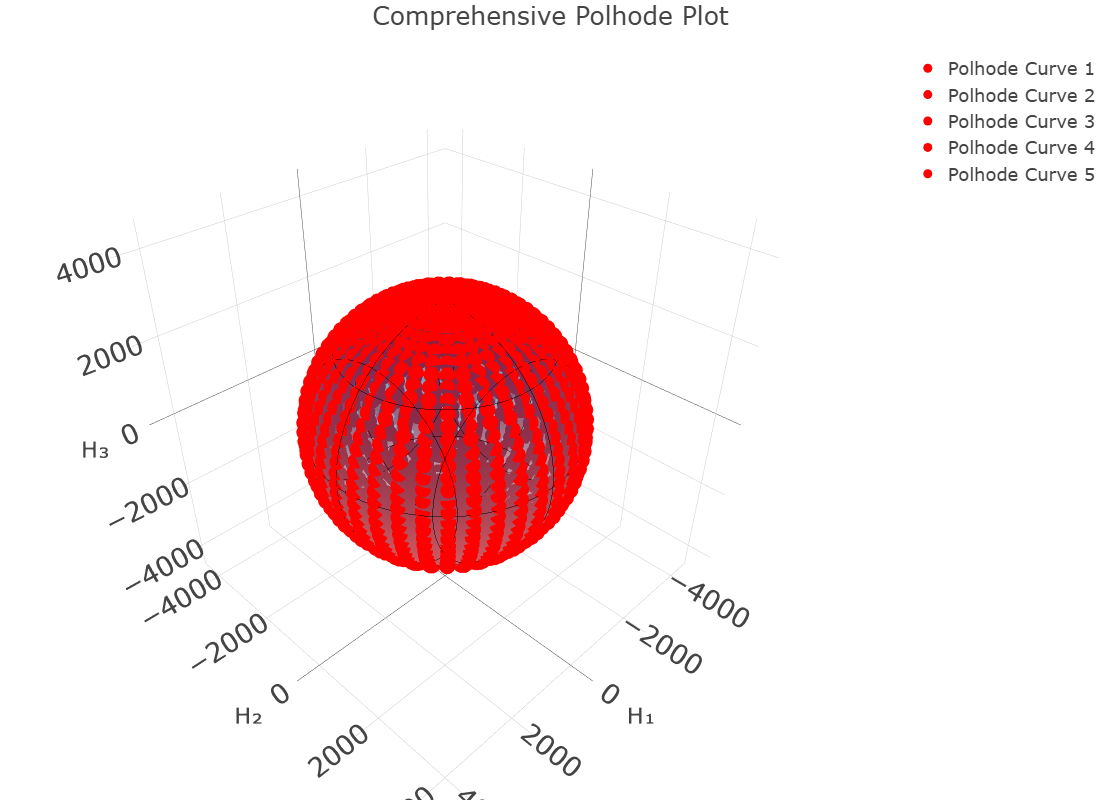

Execution time: 0.06 seconds


In [7]:
def polhode_plotter(I, omega):
    """
    Plot a comprehensive polhode plot with intersection lines for varying energy levels.
    
    Parameters:
    - I: List/Array of principal moments of inertia [I1, I2, I3].
    - omega: List/Array of body rates along the principal axes [omega_1, omega_2, omega_3].
    """
    # Start timing
    start_time = time.time()
    
    # Unpack moments of inertia and body rates
    I1, I2, I3 = I
    omega_1, omega_2, omega_3 = omega

    
    # Compute angular momentum components and magnitude
    H1 = I1 * omega_1
    H2 = I2 * omega_2
    H3 = I3 * omega_3
    H = np.sqrt(H1**2 + H2**2 + H3**2)  # Total angular momentum magnitude
    
    # Calculate minimum, intermediate, and maximum energy levels
    T_min = H**2 / (2 * I1)
    T_int = H**2 / (2 * I2)
    T_max = H**2 / (2 * I3)
    
    # Define energy levels for plotting later
    energy_levels = [T_min,                      # Minimum energy
                     (T_min + T_int) / 2,        # Midpoint between T_min and T_int
                     T_int,                      # Intermediate energy level
                     (T_int + T_max) / 2,        # Midpoint between T_int and T_max
                     T_max                       # Maximum energy
                    ]
    
    # Initialize arrays for storing curves
    all_x_curves, all_y_curves, all_z_curves = [], [], []

    # Discretize theta and phi for the momentum sphere
    # - If all three principal moments of inertia (I1, I2, I3) are equal, the energy ellipsoid reduces to a perfect sphere.
    # - In this degenerate case, the entire momentum sphere is effectively the intersection, and the computation becomes redundant.
    # - To optimize performance, we use a significantly lower angular resolution (`num_angles = 40`) since the high resolution 
    #   would waste time computing the intersection for a self-intersecting sphere.
    # - For non-degenerate cases (I1 ≠ I2 ≠ I3), we retain a high resolution (`num_angles = 750`) for accurate intersection computation.
    if np.isclose(I1, I2) and np.isclose(I2, I3):
        num_angles = 40  # Define lower angular resolution for the degenerate case
    else:
        num_angles = 750  # Define high angular resolution for general cases
    
    theta_vals = np.linspace(0, np.pi, num_angles)                # Polar angle
    phi_vals = np.linspace(0, 2 * np.pi, num_angles)              # Azimuthal angle
    theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals)

    # Compute Cartesian coordinates for the sphere
    H1_grid = H * np.sin(theta_grid) * np.cos(phi_grid)
    H2_grid = H * np.sin(theta_grid) * np.sin(phi_grid)
    H3_grid = H * np.cos(theta_grid)

    # Compute momentum sphere equation
    #sphere_eq = ne.evaluate("H1_grid**2 + H2_grid**2 + H3_grid**2 - H**2")

    # Loop over energy levels
    for T in energy_levels:
        # Calculate semi-axes of the energy ellipsoid
        a = np.sqrt(2 * I1 * T)
        b = np.sqrt(2 * I2 * T)
        c = np.sqrt(2 * I3 * T)
        #print(f"Energy Level T: {T}, Semi-Axes: a={a:.3f}, b={b:.3f}, c={c:.3f}")

        # Compute energy ellipsoid equation for filtered points
        ellipsoid_eq = ne.evaluate("H1_grid**2 / a**2 + H2_grid**2 / b**2 + H3_grid**2 / c**2 - 1") #Parallelized Vectorized Computation
        #ellipsoid_eq = H1_grid**2 / a**2 + H2_grid**2 / b**2 + H3_grid**2 / c**2 - 1               # Vectorized Computation
        
        # Combine sphere and ellipsoid equations for intersection
        tolerance = 0.005
        intersection_mask = (np.abs(ellipsoid_eq) < tolerance) #& (np.abs(sphere_eq) < tolerance)
        
        # Extract intersection points
        x_curve = H1_grid[intersection_mask]
        y_curve = H2_grid[intersection_mask]
        z_curve = H3_grid[intersection_mask]
        #print(x_curve)

        # Store intersection curves
        all_x_curves.append(x_curve)
        all_y_curves.append(y_curve)
        all_z_curves.append(z_curve)

    # Create grid for visualization of momentum sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    u_grid, v_grid = np.meshgrid(u, v)

    x_sphere = H * np.sin(v_grid) * np.cos(u_grid)
    y_sphere = H * np.sin(v_grid) * np.sin(u_grid)
    z_sphere = H * np.cos(v_grid)

    # Create figure
    fig = go.Figure()

    # Add momentum sphere
    fig.add_trace(go.Surface(x=x_sphere, y=y_sphere, z=z_sphere,
                             opacity=0.5, colorscale='Blues', showscale=False,
                             name="Momentum Sphere",
                             contours={"x": {"show": True, "color": "black"},
                                       "y": {"show": True, "color": "black"},
                                       "z": {"show": True, "color": "black"}
                                      }
                            )
                 )

    # Add polhode curves for each energy level
    for i in range(len(all_x_curves)):
        fig.add_trace(go.Scatter3d(x=all_x_curves[i].flatten(), y=all_y_curves[i].flatten(), z=all_z_curves[i].flatten(),
                                   mode='markers',
                                   line=dict(color='red', width=3),
                                   name=f"Polhode Curve {i+1}"
                                  )
                     )

    # Update the figure layout
    fig.update_layout(width=1000,
                      height=800,
                      template='presentation',
                      scene={"aspectmode": 'cube',
                             "xaxis": {"range": [-1.5*H, 1.5*H], "autorange": False, "title": "H₁"},
                             "yaxis": {"range": [-1.5*H, 1.5*H], "autorange": False, "title": "H₂"},
                             "zaxis": {"range": [-1.5*H, 1.5*H], "autorange": False, "title": "H₃"},
                            },
                      margin=dict(l=0, r=0, t=50, b=0),
                      title="Comprehensive Polhode Plot"
                     )

    # Show the plot
    fig.show()
    
    # Stop timing and print execution time
    print(f"Execution time: {time.time() - start_time:.2f} seconds")

# Define principal moments of inertia
I = [5000, 5000, 5000]

# Define body rates along principal axes
omega = [0.5, 0.3, 0.2] 

# Call the function
polhode_plotter(I, omega)